In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
np.random.seed(0)
X, Y = make_moons(500, noise=0.1)



In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=73)


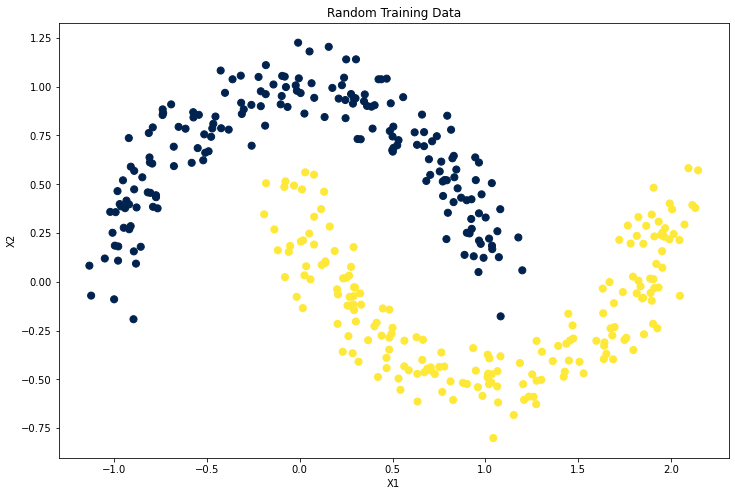

In [4]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, 
            cmap=plt.cm.cividis, s=50)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Random Training Data')
plt.show()

In [5]:
n_inputs = X_train.shape[0]
n_inputs_dim = X_train.shape[1]

In [6]:
n_h = 4 # Number of hidden nodes
n_out = 1 # Number of output nodes = for binary classifier

In [7]:
c = np.sqrt(3 / (0.5 + n_inputs_dim + n_out))
# Initialize weights and bias
W1 = np.random.uniform(low=-c, high=c, 
                    size=(n_inputs_dim, n_h))
b1 = np.zeros((1, n_h))
W2 = np.random.uniform(low=-c, high=c,
                       size=(n_h, n_out))
b2 = np.zeros((1, n_out))

In [8]:
def Elu(x, a=2):
    """
    Compute the ELU output of x
    """
    return np.where(x<=0, a * (np.exp(x) - 1), x)




In [9]:
def sigmoid(x):
    """
    Compute sigmoid of array x
    """
    return 1 / (1 + np.exp(-x))

In [10]:
Z1 = np.dot(X_train, W1) + b1
A1 = Elu(Z1)
Z2 = np.dot(A1, W2) + b2
A2 = sigmoid(Z2)


In [11]:
Y_train = Y_train.reshape(-1,1)
log_probs = (np.multiply(np.log(A2), Y_train) + 
        np.multiply(np.log(1 - A2), (1 - Y_train)))
loss = -1 / n_inputs * np.sum(log_probs)
loss

0.6395828151201088

In [12]:
def dElu(x, a=2):
    return np.where(x<=0,a * np.exp(x), 0)


In [13]:
m = 1 / n_inputs
dZ2 = A2 - Y_train
dW2 = m * np.dot(A1.T, dZ2)
db2 = m * np.sum(dZ2, axis=0, keepdims=True)
dZ1 = m * np.dot(dZ2, W2.T) * dElu(Z1)
dW1 = m * np.dot(X_train.T, dZ1)
db1 = m * np.sum(dZ1, axis=0, keepdims=True)

In [14]:
learning_rate = 0.01
W2 -= learning_rate * dW2
b2 -= learning_rate * db2
W1 -= learning_rate * dW1
b1 -= learning_rate * db1


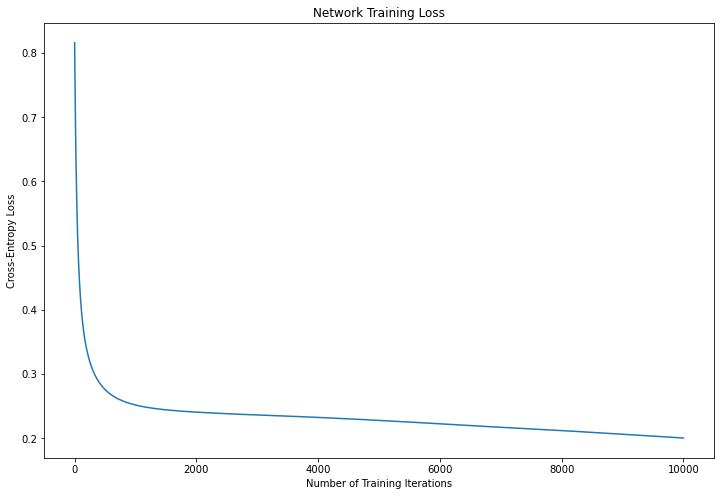

Training Accuracy: 0.92


In [15]:
class network():
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.n_input_dim = X.shape[1]
        self.n_output_dim = 1
        self.n_inputs = X.shape[0]
        
    def initialize(self, n_hidden, seed=1):
        self.n_hidden = n_hidden
        np.random.seed(seed)
        c = np.sqrt(3 / (0.5 + self.n_input_dim + self.n_output_dim))
        W1 = np.random.uniform(low=-c, high=c, 
                    size=(self.n_input_dim, self.n_hidden))
        b1 = np.zeros((1, self.n_hidden))
        W2 = np.random.uniform(low=-c, high=c,
                              size=(self.n_hidden, self.n_output_dim))
        b2 = np.zeros((1, self.n_output_dim)) 
        
        self.params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        self.cache = {}
        
    def Elu(self, x, a=2):
        return np.where(x<=0, (a * (np.exp(x) - 1)), x)
    
    def dElu(self, x, a=2):
        return np.where(x<=0, a * np.exp(x), 1)
    
    def sigmoid(self, x):
        return 1. / (1 + np.exp(-x))
    
    def forward_prop(self, X=None, cache=True):
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        if X is None:
            X = self.X.copy()
        
        Z1 = X.dot(W1) + b1
        A1 = self.Elu(Z1)
        Z2 = np.dot(A1, W2) + b2
        A2 = self.sigmoid(Z2)
        probs = A2
        
        if cache:
            self.cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 
                          'A2': A2, 'probs': probs} 
        else:
            return probs
    
    def back_prop(self):
        # Import parameters and cached values
        A1 = self.cache['A1']
        A2 = self.cache['A2']
        W1 = self.params['W1']
        b1 = self.params['b1']
        W2 = self.params['W2']
        b2 = self.params['b2']
        
        # Calculate derivatives
        m = 1 / self.n_inputs
        dZ2 = A2 - self.Y.reshape(-1,1)
        dW2 = m * A1.T.dot(dZ2)
        db2 = m* np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = m * dZ2.dot(W2.T) * self.dElu(A1)
        dW1 = m * np.dot(self.X.T, dZ1)
        db1 = m * np.sum(dZ1, axis=0)
        
        # Apply gradient descent updates
        W1 -= self.learning_rate * dW1
        b1 -= self.learning_rate * db1
        W2 -= self.learning_rate * dW2
        b2 -= self.learning_rate * db2
        
        # Store updated network parameters
        self.params = {'W1': W1, 'b1': b1, 
                       'W2': W2, 'b2': b2}
        
    def train(self, learning_rate=1e-2, 
              n_iters=10000, log_loss=False):
        self.learning_rate = learning_rate
        loss = []
        # Train the network
        for i in range(n_iters):
            self.forward_prop()
            self.back_prop()
            
            # Calculate the loss value to track progress
            if log_loss:
                loss.append(self.calculate_loss())
                
        if log_loss:
            return loss
    
    def predict(self, X):
        probs = self.forward_prop(X, cache=False)
        return np.where(probs<0.5,0,1)
    
    def calculate_loss(self):
        probs = self.cache['probs']
        W1 = self.params['W1']
        W2 = self.params['W2']
        Y = self.Y.reshape(-1,1)
        loss = (np.multiply(np.log(probs), Y) + 
                np.multiply(np.log(1 - probs), (1 - Y)))
        return -1 / self.n_inputs * np.sum(loss)
    
    def train_accuracy(self):
        probs = self.cache['probs']
        clf = np.where(probs<0.5, 0, 1)
        return np.sum(self.Y.reshape(-1,1)==clf) / self.n_inputs
    
    # Call this function to view the decision boundary
    def plot_decision_boundary(self):
        
        # Determine grid range in x and y directions
        x_min, x_max = self.X[:, 0].min()-0.1, self.X[:, 0].max()+0.1
        y_min, y_max = self.X[:, 1].min()-0.1, self.X[:, 1].max()+0.1
   
        # Set grid spacing parameter
        spacing = min(x_max - x_min, y_max - y_min) / 100

        # Create grid
        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))
    
        # Concatenate data to match input
        data = np.hstack((XX.ravel().reshape(-1,1), 
                          YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        clf = self.predict(data)
    
        Z = clf.reshape(XX.shape)
        
        plt.figure(figsize=(10,8))
        plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(self.X[:,0], self.X[:,1], c=self.Y, 
                    cmap=plt.cm.cividis, s=50)
        plt.show()


# In[14]:


net = network(X_train, Y_train)
net.initialize(n_hidden=3)




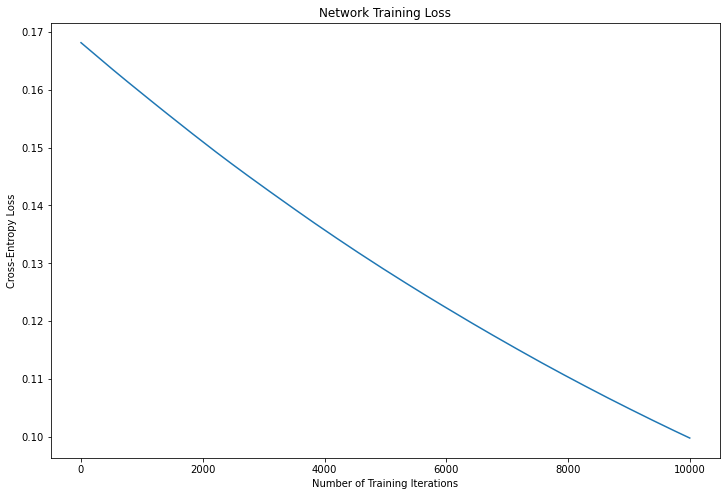

Training Accuracy: 0.97


In [20]:
training_loss = net.train(learning_rate=0.1, log_loss=True)
plt.figure(figsize=(12,8))
plt.plot(training_loss)
plt.title("Network Training Loss")
plt.xlabel("Number of Training Iterations")
plt.ylabel("Cross-Entropy Loss")
plt.show()

print("Training Accuracy: %.2f" %net.train_accuracy())

In [21]:
pred = net.predict(X_test)
np.sum(Y_test.reshape(-1,1)==pred) / len(Y_test)

0.952

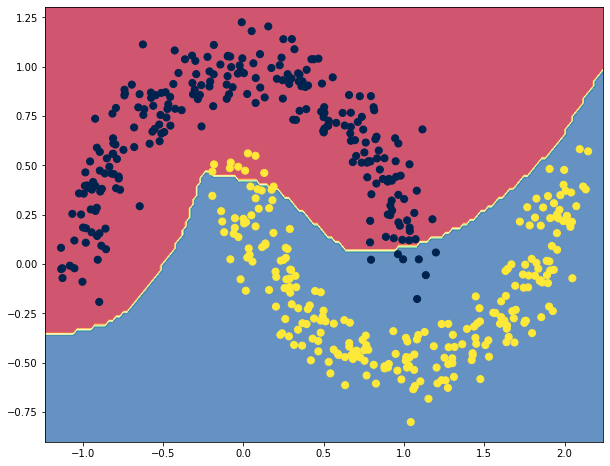

In [22]:
net.plot_decision_boundary()


In [23]:

n_hidden = [10]

10 Hidden Nodes


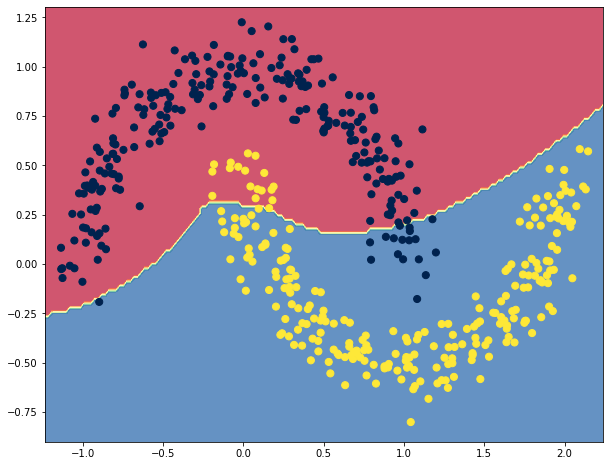

In [24]:
for n in n_hidden:
    net = network(X, Y)
    net.initialize(n_hidden=n)
    net.train(learning_rate=0.1, log_loss=False)
    print("%d Hidden Nodes" %n)
    net.plot_decision_boundary()
    